In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mapply
mapply.init(n_workers=-1)

In [13]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [14]:
train_df.shape

(7613, 5)

In [15]:
test_df.shape

(3263, 4)

In [16]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [17]:
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


### Counting NaN values

In [18]:
train_df[["keyword", "location"]].isnull().sum()

keyword       61
location    2533
dtype: int64

In [19]:
test_df[["keyword", "location"]].isnull().sum()

keyword       26
location    1105
dtype: int64

### Number of disaster tweets

<AxesSubplot:xlabel='target'>

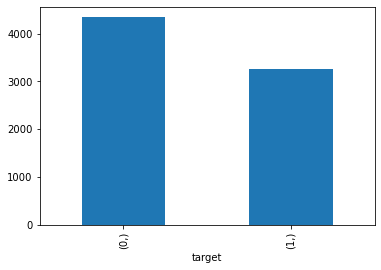

In [20]:
train_df[["target"]].value_counts().plot(kind = "bar")

### Disaster tweets by location

In [21]:
train_df[train_df['target'] == 1].groupby("location").count().\
sort_values("id", ascending = False)

,id,keyword,text,target
location,,,,
USA,67,67,67,67
United States,27,27,27,27
Nigeria,22,22,22,22
India,20,20,20,20
Mumbai,19,19,19,19
...,...,...,...,...
Himalayan Mountains,1,1,1,1
Hertfordshire,1,1,1,1
"Here, unless there.",1,1,1,1


### Disaster tweets by keyword 

In [22]:
train_df[train_df['target'] == 1].groupby("keyword").count().\
sort_values("id", ascending = False)

,id,location,text,target
keyword,,,,
derailment,39,25,39,39
wreckage,39,28,39,39
outbreak,39,30,39,39
debris,37,22,37,37
oil%20spill,37,27,37,37
...,...,...,...,...
blazing,1,1,1,1
epicentre,1,1,1,1
body%20bag,1,1,1,1


### Cleaning up the data 

In [23]:
import re
import string
import emoji

def clean_up_text(text):
    
    text = re.sub(r'%[0-9]+','', text)
    text = re.sub(r'amp|new|via','', text)
    text = re.sub(r'@[A-Za-z0-9_]+','', text)
    text = re.sub(r'#','', text)
    text = re.sub(r'RT : ','', text)
    text = re.sub(r'\n','', text)
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','', text)
    text = re.sub(r"https?://\S+|www\.\S+","", text)
    text = re.sub(r"<.*?>","", text)
    text = re.sub(emoji.get_emoji_regexp(), r"", text)
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    text = re.sub(" +"," ", text) 
    text = re.sub("\b\w\b","",text)
    text = str.lower(text)
    return text

In [24]:
train_df["text"] = train_df["text"].mapply(clean_up_text)
test_df["text"] = test_df["text"].mapply(clean_up_text)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Correct Misspelled words 

In [25]:
from spellchecker import SpellChecker
spell_checker = SpellChecker()

def correct_misspelled_words(text):
    correct_text = []
    for w in text.split(" "):
        if w in spell_checker.unknown(text.split(" ")):
            correct_text.append(spell_checker.correction(w))
        else: correct_text.append(w)
    return " ".join(correct_text)

In [26]:
train_df["text"] = train_df["text"].mapply(correct_misspelled_words)
test_df["text"] = test_df["text"].mapply(correct_misspelled_words)

### Removing Stop words 

In [27]:
import nltk
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

def remove_stopwords(text):
    text = [w.lower() for w in text.split() \
            if w.lower() not in stopwords_set]
    return " ".join(text)

In [28]:
train_df["text"] = train_df["text"].mapply(remove_stopwords)
test_df["text"] = test_df["text"].mapply(remove_stopwords)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Lemmatizing the tweets

In [29]:
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

def stem_text(text):
    text = [stemmer.lemmatize(w) for w in text.split(" ")]
    return " ".join(text)

In [30]:
train_df["text"] = train_df["text"].mapply(stem_text)
test_df["text"] = test_df["text"].mapply(stem_text)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [31]:
train_df[train_df['target'] == 1]["text"]

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       13 000 people receive wildfire evacuation orde...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    control wild fire california even northern par...
7610                   m1 94 01 04 utc 5km volcano hawaii
7611    police investigating e bike collided car littl...
7612    latest home razed northern california wildfire...
Name: text, Length: 3271, dtype: object

In [32]:
test_df["text"]

0                             happened terrible car crash
1       heard earthquake different city stay safe ever...
2       forest fire spot pond goose fleeing across str...
3                    apocalypse lighting spokane wildfire
4                   typhoon soudelor kill 28 china taiwan
                              ...                        
3258    earthquake safety los angeles safety fastener ...
3259    storm ri worse last hurricane city 3others har...
3260                        green line derailment chicago
3261              meg issue hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

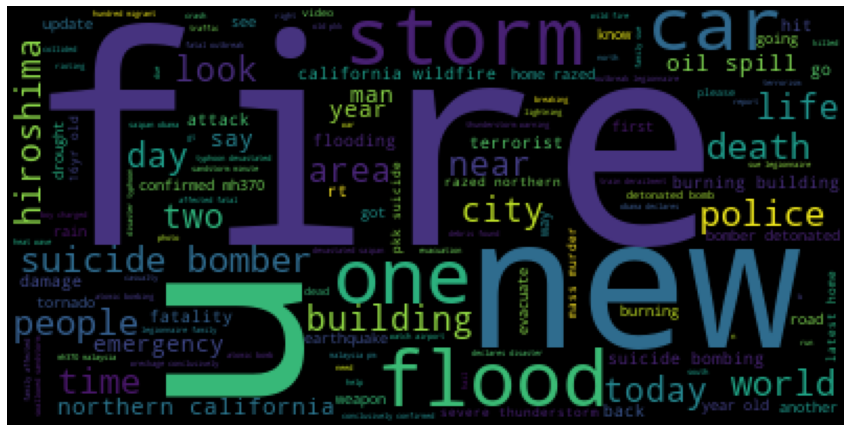

In [33]:
from wordcloud import WordCloud

wordcloud_1 = WordCloud().generate(" ".join(train_df[train_df['target'] == 1]["text"].to_list()))
plt.figure(figsize = (15, 20), facecolor = None) 
plt.imshow(wordcloud_1)
plt.axis("off")
plt.show()

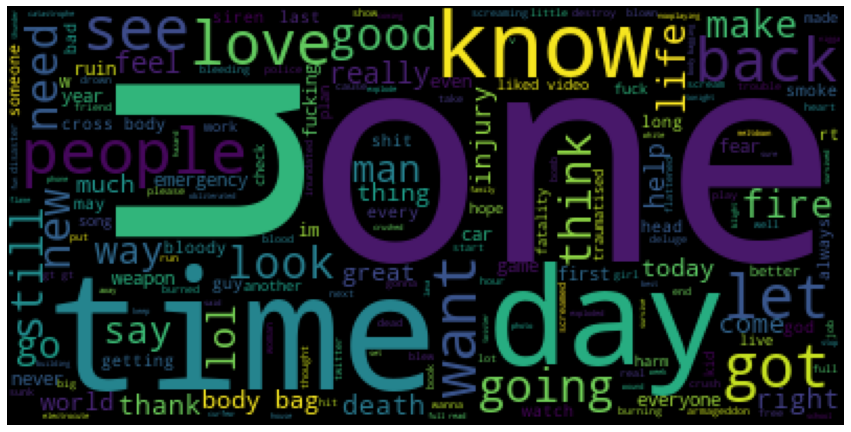

In [34]:
wordcloud_0 = WordCloud().generate(" ".join(train_df[train_df['target'] == 0]["text"].to_list()))
plt.figure(figsize = (15, 20), facecolor = None) 
plt.imshow(wordcloud_0)
plt.axis("off")
plt.show()

### Vectorize the corpus using TFIDF Vectorizer 

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words=stopwords.words('english'))
X = tfidf_vectorizer.fit_transform(train_df["text"]).toarray()

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, train_df["target"], test_size=0.2, random_state=0)

### Baseline RandomForest Model 

In [37]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs = -1)
classifier.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [38]:
y_pred = classifier.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test,y_pred))
print(f'Accuracy : {accuracy_score(y_test, y_pred) * 100:.2f}%')

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       886
           1       0.79      0.69      0.74       637

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Accuracy : 79.32%
